In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from run_evolution import folder_evol
from analytical_results import fT00, fT01, fT11, fj0, fj1, fnu, fLn
from ploting import plot_heatmaps

In [2]:
g = 1
v, Q = 1, 1
tol, method = 1e-6, '12site'
D0, D = 256, 256
#
# ms = [0, 0.1, 0.2, 0.318309886, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0]  # [ 1.1, 1.2, 1.5, 2.0] #
ms = [0.7]
# ms = [0.1, 0.2, 0.318309886, 0.4, 0.5, 0.6, 0.7, 0.8,]
mg = [g * x for x in ms]
NaDdt = [(512, 0.125, 1024, 1/16),  (1024, 0.125, 256, 1/16), (512, 0.25, 256, 1/16), (512, 0.25, 1024, 1/16)]


# NaDdt = [ (1024, 0.125, 256, 1/16)]
# [ (512, 0.25, 256, 1/16), (512, 0.25, 1024, 1/16), (512, 0.25, 2024, 1/16)] #, (1024, 0.0625, 2, 1/16)]
# (512, 0.125, 256, 1/16),
data = {}

for m in ms:
    for N, a, D, dt in NaDdt:
        D0 = D
        try:
            folder = folder_evol(g, m, a, N, v, Q, D0, dt, D, tol, method, mkdir=False)
            data[m, N, a, D, dt] = np.load(folder / f"results.npy", allow_pickle=True).item()
        except FileNotFoundError:
            pass

In [3]:
NUM_COLORS = 15
cm = plt.get_cmap('gist_rainbow')
colors = [cm(i / NUM_COLORS) for i in range(NUM_COLORS)]
lines = [':', '--', '-', '-.']

In [4]:
def get_tsm(signals, ev):
    tm = signals["time"]
    mask = tm > -1
    tm = tm[mask]
    ee = signals[ev][mask]
    ee = ee - ee[0, :]
    ee = (ee[:, 0::2] + ee[:, 1::2]) / 2  # average over 2*n and 2*n+1
    mid = (ee[:, N//4] +ee[:, N//4-1])/2
    return tm, ee, mid


In [5]:
data.keys()

dict_keys([(0.7, 512, 0.125, 1024, 0.0625), (0.7, 1024, 0.125, 256, 0.0625), (0.7, 512, 0.25, 256, 0.0625), (0.7, 512, 0.25, 1024, 0.0625)])

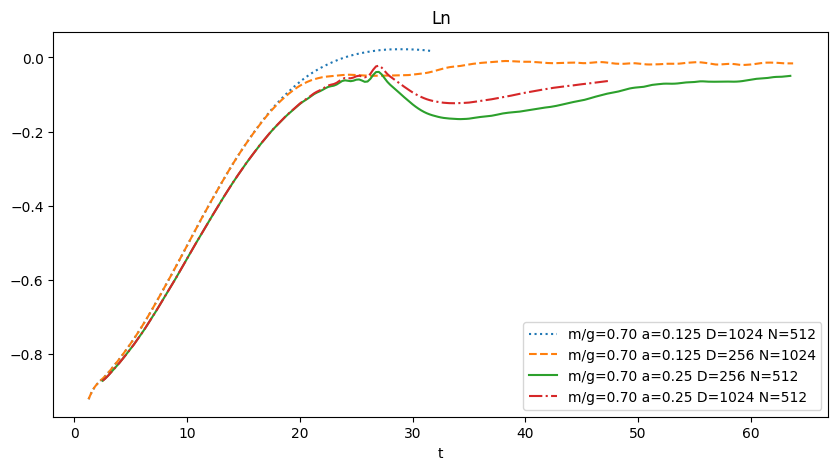

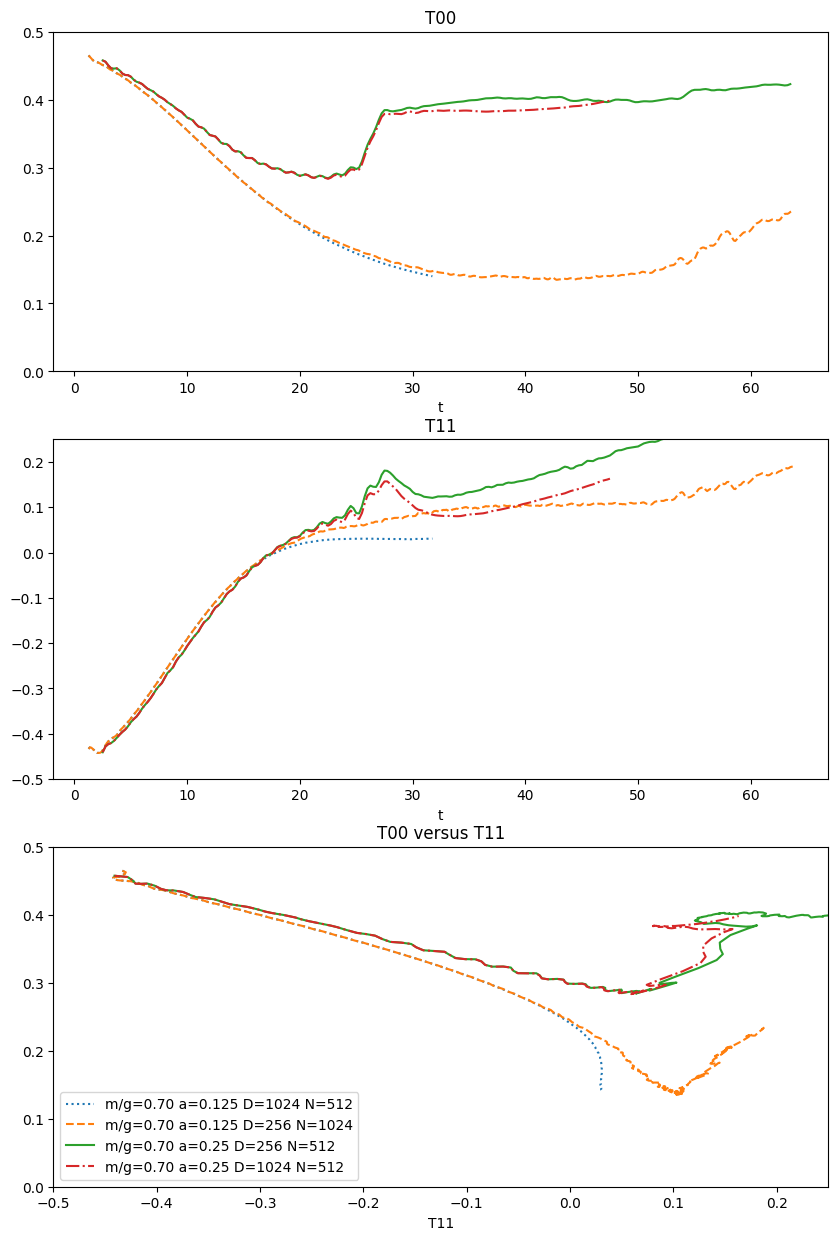

In [6]:
plt.figure(figsize=(10, 5))

for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        tm, ee, mid = get_tsm(data[m, N, a, D, dt], 'Ln')
        line, = plt.plot(tm[10:-2], mid[10:-2], lines[j])
        line.set_label(f'{m/g=:.2f} {a=} {D=} {N=}')

plt.legend()
plt.xlabel('t')
plt.title('Ln')

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        tm, ee, midE = get_tsm(data[m, N, a, D, dt], 'T00')
        tm, ee, midp = get_tsm(data[m, N, a, D, dt], 'T11')
        ax[0].plot(tm[10:-2], midE[10:-2], lines[j], label=f'{m/g=:.2f} {a=} {D=} {N=}')
        ax[1].plot(tm[10:-2], midp[10:-2], lines[j], label=f'{m/g=:.2f} {a=} {D=} {N=}')
        ax[2].plot(midp[10:-2], midE[10:-2], lines[j], label=f'{m/g=:.2f} {a=} {D=} {N=}')

ax[0].set_title('T00')
ax[1].set_title('T11')
ax[2].set_title('T00 versus T11')

ax[0].set_xlabel('t')
ax[1].set_xlabel('t')
ax[2].set_xlabel('T11')

ax[0].set_ylim([0, 0.5])
ax[1].set_ylim([-0.5, 0.25])
ax[2].set_xlim([-0.5, 0.25])
ax[2].set_ylim([0, 0.5])

ax[2].legend()


In [7]:
# test energy from MPO vs T00
for i, m in enumerate(ms):
    for j, (N, a, D, dt) in enumerate(NaDdt):
        mask = data[m, N, a, D, dt]["time"] > -1  # when some points not calculated yet
        x1 = np.sum(data[m, N, a, D, dt]["T00"][mask, :], axis=1) * a
        x2 = data[m, N, a, D, dt]["energy"][mask]
        assert np.max(np.abs((np.abs(1 - x1 / x2) ))) < 1e-8

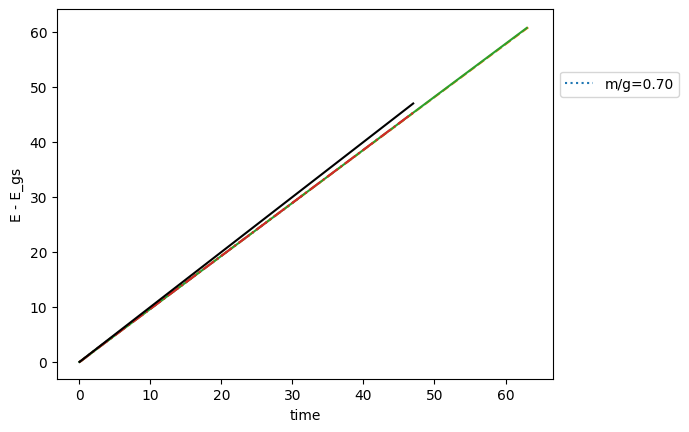

In [8]:
for i, m in enumerate(ms):
    for j, (N, a, D, dt) in enumerate(NaDdt):
        tm = data[m, N, a, D, dt]["time"]
        mask = tm > -1
        tm = tm[mask]
        en = data[m, N, a, D, dt]["energy"][mask]
        line, = plt.plot(tm[:-4], en[:-4] - en[0], lines[j],)
        if j == 0:
            line.set_label(f"{m/g=:0.2f}")

plt.plot(tm[:-4], tm[:-4], '-k')

plt.xlabel('time')
plt.ylabel('E - E_gs')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

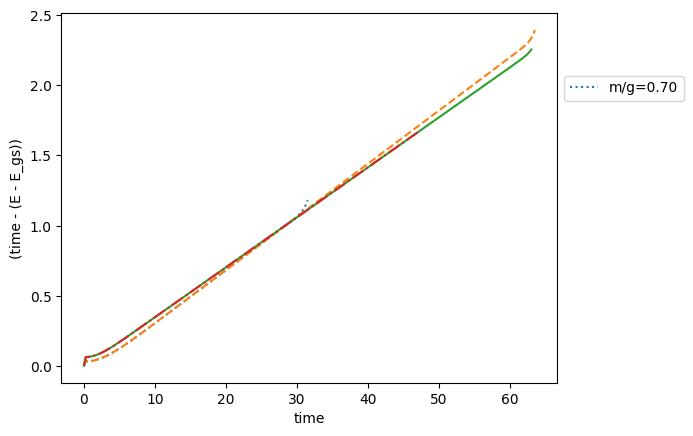

In [9]:
for i, m in enumerate(ms):
    for j, (N, a, D, dt) in enumerate(NaDdt):
        tm = data[m, N, a, D, dt]["time"]
        mask = tm > -1
        tm = tm[mask]
        en = data[m, N, a, D, dt]["energy"][mask]
        line, = plt.plot(tm[:-4], (tm[:-4] - (en[:-4] - en[0])), lines[j],)
        if j == 0:
            line.set_label(f"{m/g=:0.2f}")

plt.xlabel('time')
plt.ylabel('(time - (E - E_gs))')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

In [10]:
NaDdt

[(512, 0.125, 1024, 0.0625),
 (1024, 0.125, 256, 0.0625),
 (512, 0.25, 256, 0.0625),
 (512, 0.25, 1024, 0.0625)]

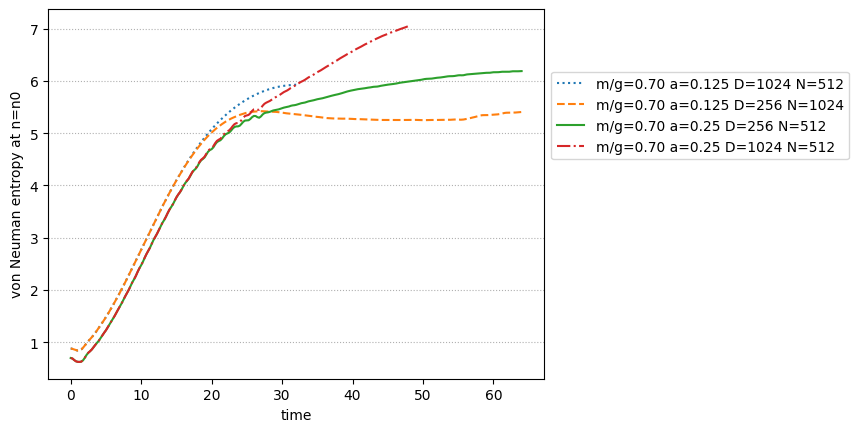

In [11]:
for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        tm = data[m, N, a, D, dt]["time"]
        mask = tm > -1
        tm = tm[mask]

        ee = data[m, N, a, D, dt]["entropy_1"][mask]
        # ee = ee - ee[0]

        line, = plt.plot(tm, ee[:, N // 2] , lines[j])
        line.set_label(f'{m/g=:.2f} {a=} {D=} {N=}')

plt.grid(axis="y", linestyle=':')

plt.xlabel('time')
plt.ylabel('von Neuman entropy at n=n0')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

von Neuman entropy between left and right parts of the lattice; We subtract values in the initial state.

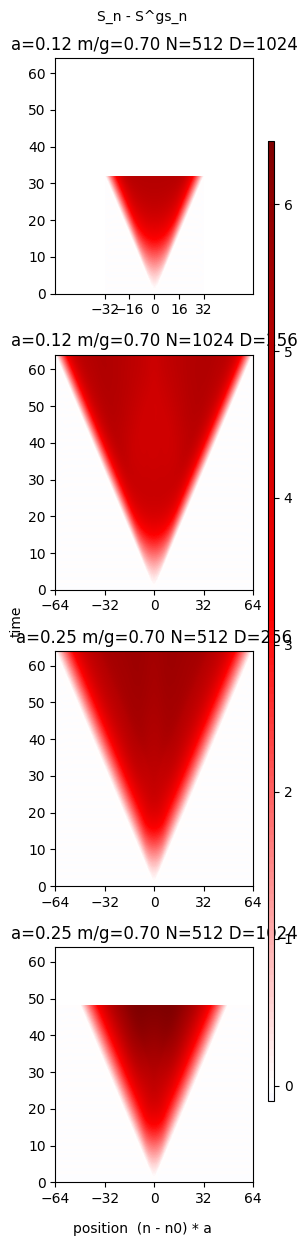

In [12]:
plot_heatmaps('entropy_1', 'S_n - S^gs_n', data, NaDdt, ms, g, subtract_t0=True, avarage_nn=False, tmax=64)

T00 - T00(t=0);  We might avarage over [2*l, 2*l+1] sites.


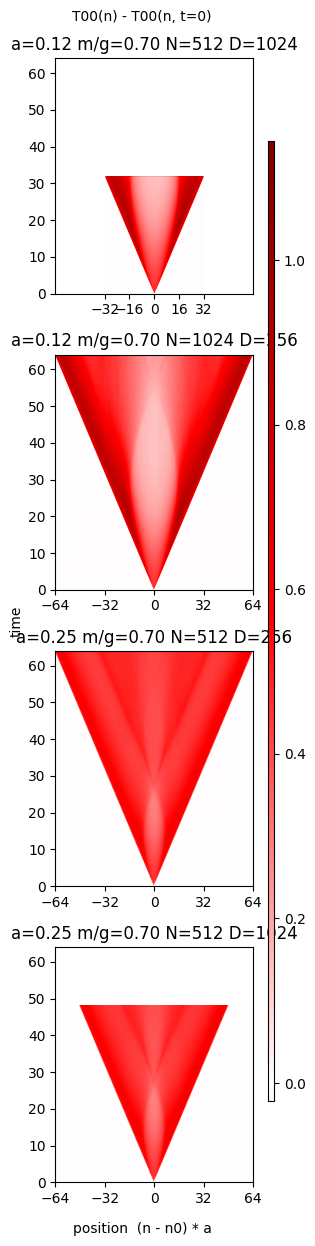

In [13]:
plot_heatmaps("T00", 'T00(n) - T00(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=True, tmax=64)

T11; We avarage over [2*l, 2*l+1] sites, and subtract initial value.

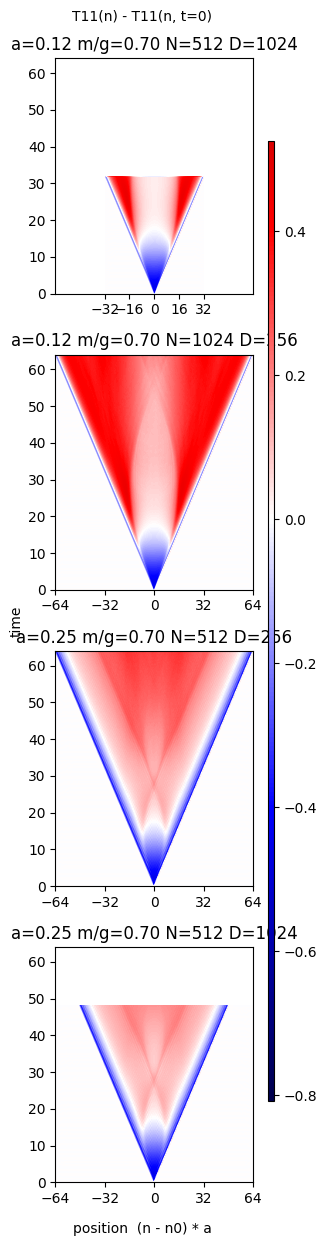

In [14]:
plot_heatmaps("T11", 'T11(n) - T11(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=True, tmax=64)

T01 - T01(t=0); We can avarage over [2*l, 2*l+1] sites.

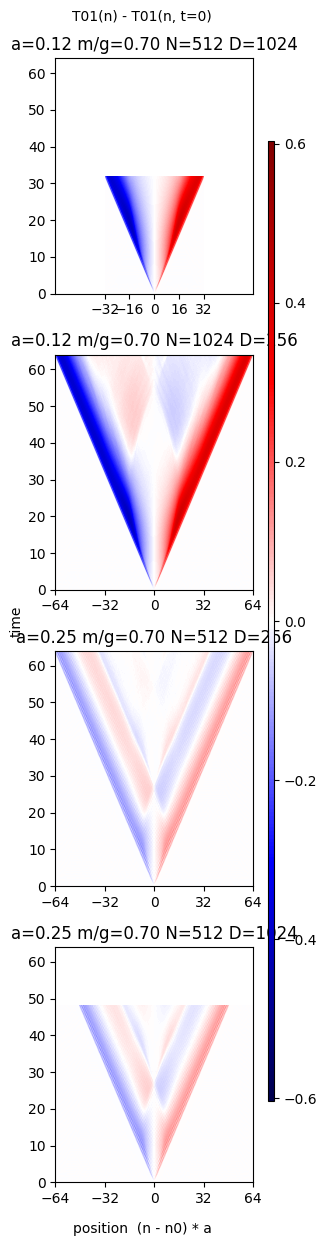

In [15]:
plot_heatmaps("T01", 'T01(n) - T01(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=True, tmax=64)

j0; subtract j0(t=0)

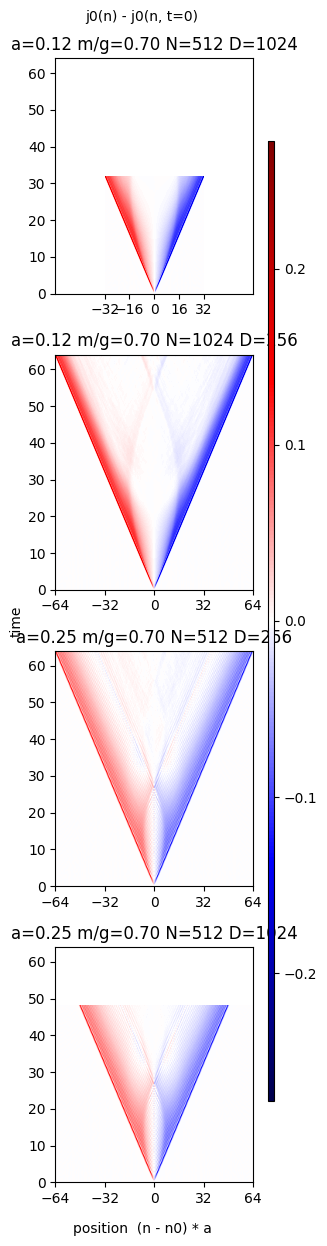

In [16]:
plot_heatmaps("j0", 'j0(n) - j0(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=False, tmax=64)

j1;

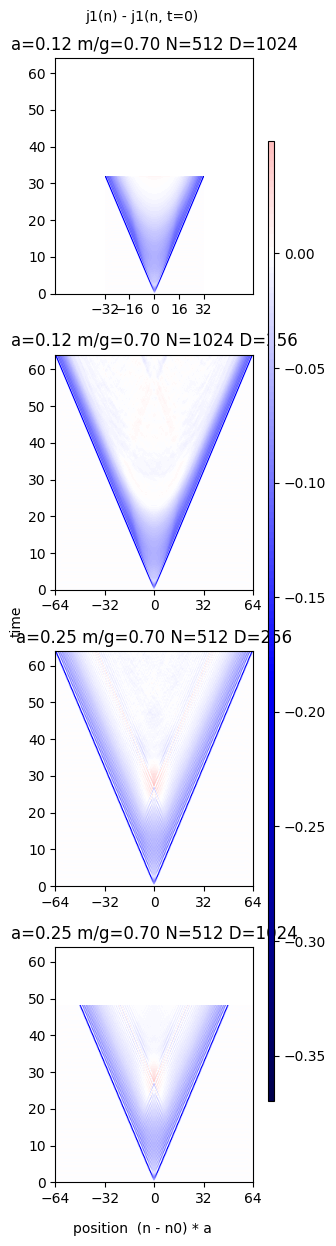

In [17]:
plot_heatmaps("j1", 'j1(n) - j1(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=False, tmax=64)

condensate

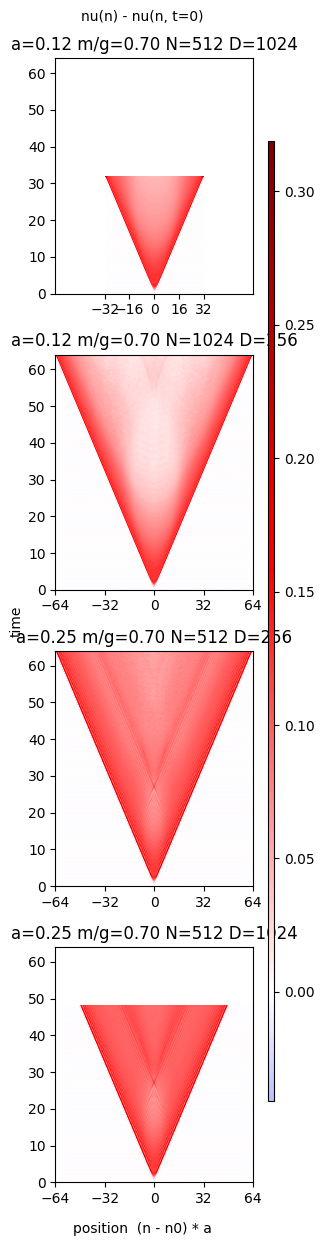

In [18]:
plot_heatmaps("nu", 'nu(n) - nu(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=False, tmax=64)

Ln

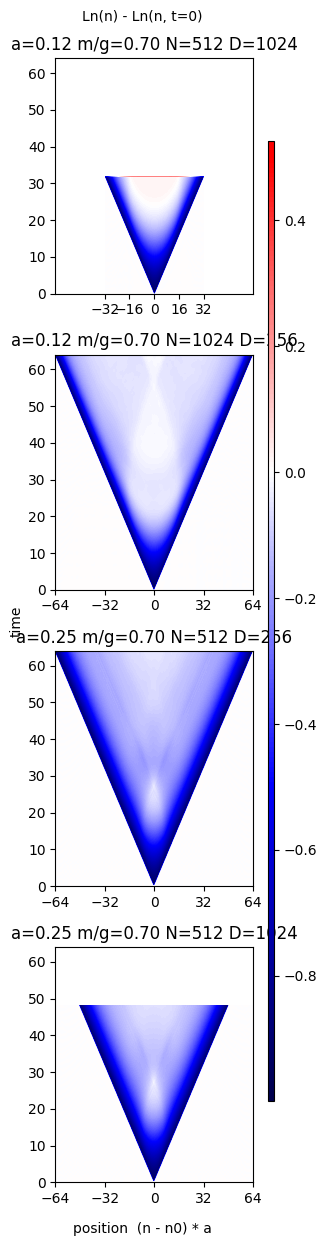

In [19]:
plot_heatmaps("Ln", 'Ln(n) - Ln(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=False, tmax=64)

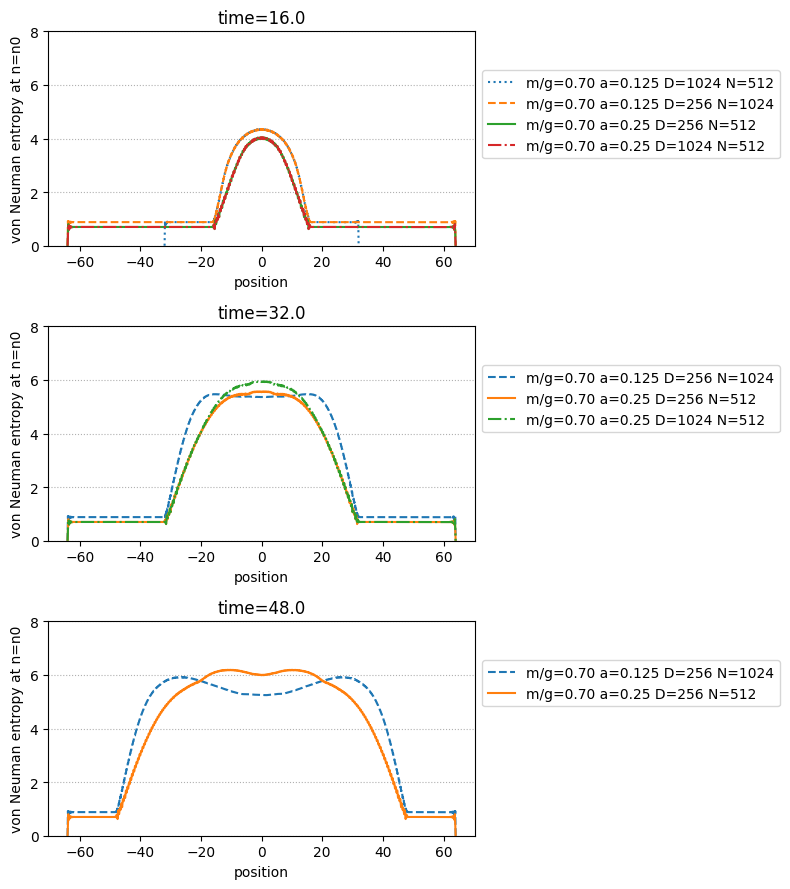

In [20]:
times = [16, 32, 48]

fig, ax = plt.subplots(len(times), 1)
fig.set_size_inches(8, 3 * len(times))

for k, time in enumerate(times):
    for j, (N, a, D, dt) in enumerate(NaDdt):
        for i, m in enumerate(ms):
            tm = data[m, N, a, D, dt]["time"]
            mask = tm > -1
            tm = tm[mask]

            ee = data[m, N, a, D, dt]["entropy_1"][mask]
            # ee = ee - ee[0]

            ii = np.argmin(abs(tm - time))

            if ii < len(tm) - 1:
                xx = np.linspace(-a * N / 2, a * N / 2, len(ee[ii, :]))
                line, = ax[k].plot(xx, ee[ii, :] , lines[j])
                line.set_label(f'{m/g=:.2f} {a=} {D=} {N=}')


    ax[k].grid(axis="y", linestyle=':')
    ax[k].set_title(f'{time=:0.1f}')
    ax[k].set_xlabel('position')
    ax[k].set_ylabel('von Neuman entropy at n=n0')
    ax[k].legend(ncols=1, bbox_to_anchor=(1, 0.85))
    ax[k].set_ylim([0, 8])
fig.tight_layout()